In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az


## 1. Bayseian modeling
### 1.1. statistical models 
binominal distribution\
nomal distribution\
linear regression

### source
[1] https://people.duke.edu/~ccc14/sta-663-2016/16D_PyStan.html \
[2] https://mc-stan.org/docs/stan-users-guide/index.html \
[3] model selection: https://mc-stan.org/docs/stan-users-guide/linear-regression.html#vectorization.section \
[4] Stan function reference guide: https://mc-stan.org/docs/2_18/reference-manual/vector-and-matrix-data-types.html


In [6]:
import stan

In [7]:
import nest_asyncio #this library is important to use pystan

nest_asyncio.apply()

In [8]:
import pandas as pd
import csv

In [9]:
import scipy.stats as stats

In [10]:
## import data

df = pd.read_csv('./db/diabetes.csv')

### purpose of analysis
The goal of this analysis is to understand how liklihood of diabetes happened with the age of pregnancies.\
In order to understand it, we will use a bayesian linear regression model.


#### 1. EDA
In order to set initial assumption as prior distribution, we conducted EDA to plot distribution of age and diabetes (DiabetesPedigreeFunction).

source: https://sakurachaojun.github.io/PSYO3505/data/EDA.html

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [12]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [13]:
df["age_over35"] = (df['Age'] > 35).astype(int)

In [14]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_over35
0,6,148,72,35,0,33.6,0.627,50,1,1
1,1,85,66,29,0,26.6,0.351,31,0,0
2,8,183,64,0,0,23.3,0.672,32,1,0
3,1,89,66,23,94,28.1,0.167,21,0,0
4,0,137,40,35,168,43.1,2.288,33,1,0
5,5,116,74,0,0,25.6,0.201,30,0,0
6,3,78,50,32,88,31.0,0.248,26,1,0
7,10,115,0,0,0,35.3,0.134,29,0,0
8,2,197,70,45,543,30.5,0.158,53,1,1
9,8,125,96,0,0,0.0,0.232,54,1,1


/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/ipykernel_42316/408525778.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.DiabetesPedigreeFunction,color='r')


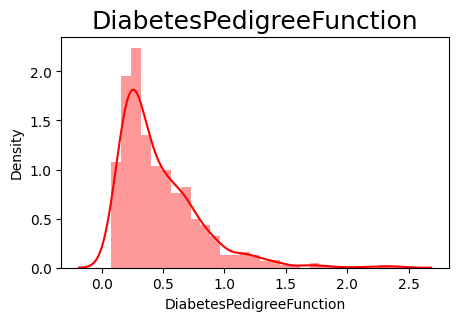

In [15]:
plt.figure(figsize=(5,3))
sns.distplot(df.DiabetesPedigreeFunction,color='r')
plt.title('DiabetesPedigreeFunction',size=18)
# plt.xlabel('Charges',size=14)
# plt.ylabel('Density',size=14)
plt.show()

<Axes: xlabel='Age', ylabel='DiabetesPedigreeFunction'>

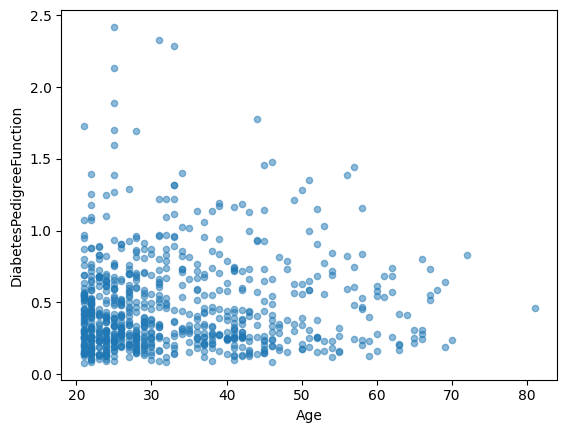

In [16]:
# print(df.loc[:, 'Outcome'].values)
df.sort_values(by='Age').reset_index(drop=True).plot.scatter(x='Age', y="DiabetesPedigreeFunction", alpha=0.5)

#### 2. Explain the model
1. Data variables\
   1.1. The dependent variable is age, and the independent variable is diabetes.
2. Likelihood function and parameters
5. Prior distribution
6. Formal specification
7. Prior predictive check

#### 3. Details of the computation



In [17]:
stan_code = """
data {
    // num of observation
    int<lower=0> N;
    // num of success
     vector[N] diabetes;
     int<lower=0> age[N];
     int<lower=0> glucos[N];
     int<lower=0> skinTickness[N];
     
}

parameters {
    //prob of success
    real alpha;
    real beta1;
    real beta2;
    real beta3;
    real<lower=0> sigma;
}


model {
    //prior
    alpha ~ normal(0, 1);
    beta1 ~ normal(0, 1);
    beta2 ~ normal(0, 1);
    beta3 ~ normal(0, 1);
    
    sigma ~ cauchy(0, 10);
    diabetes ~ normal(alpha + beta1 * to_vector(age) + beta2 * to_vector(glucos) + beta3 * to_vector(skinTickness), sigma); //likelihood
}

generated quantities {
    vector[N] diabetes_rep;

    for (n in 1:N){
     diabetes_rep [n] = normal_rng(alpha + beta1 * age[n] + beta2 * glucos[n] + beta3 * skinTickness[n], sigma);
    }
}

"""


In [18]:
data = {
"N": len(df), 
"diabetes": df.loc[:, "DiabetesPedigreeFunction"].values,
"age": df.loc[:, "Age"].values,
"glucos": df.loc[:, "Glucose"].values,
"skinTickness": df.loc[:, "SkinThickness"].values
}

In [19]:
stan_model = stan.build(stan_code, data=data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_woxinos8/model_rrqnghow.stan', line 7, column 5: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_woxinos8/model_rrqnghow.stan', line 8, column 5: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_woxinos8/model_rrqnghow.stan', line 9, column 5: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will b

In [20]:
fit = stan_model.sample(num_chains=4, num_samples=1000) ## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   1% (101/8000)
Sampling:   1% (102/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (601/8000)
Sampling:   9% (701/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  42% (3400/8000)
Sampling:  46% (3700/8000)
Sampling:  61% (4900/8000)
Sampling:  81% (6500/8000)
Sampling:  89% (7100/8000

In [21]:
stan_data = az.from_pystan(
    posterior=fit,
    posterior_predictive="diabetes_rep",
    observed_data=["diabetes"],
    coords={"diabetes": np.arange(data["N"])},
)


In [22]:
stan_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats

In [23]:
output = fit.to_frame()

In [24]:
output.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta1,beta2,...,diabetes_rep.759,diabetes_rep.760,diabetes_rep.761,diabetes_rep.762,diabetes_rep.763,diabetes_rep.764,diabetes_rep.765,diabetes_rep.766,diabetes_rep.767,diabetes_rep.768
draws,,,,,,,,,,,,,,,,,,,,,
0,479.754130,0.996878,0.027854,5.0,55.0,0.0,-477.383976,0.214271,0.000941,0.001471,...,0.743216,0.808737,1.220306,0.535641,0.457438,0.498999,0.495631,0.131470,0.002534,1.167920
1,481.970252,0.966476,0.027180,7.0,127.0,0.0,-480.852081,0.153450,0.000975,0.001655,...,0.093329,0.536472,0.292525,0.757542,0.170618,0.284249,0.441430,0.279362,0.368859,0.522080
2,481.742483,0.998911,0.028253,5.0,63.0,0.0,-479.707824,0.237600,-0.000411,0.001553,...,0.433970,0.736395,0.312254,0.216727,-0.271740,0.069224,0.661451,0.380028,0.671380,0.081231
3,483.174783,0.927732,0.027221,5.0,59.0,0.0,-480.814503,0.188683,0.000592,0.001519,...,0.888132,0.839526,0.115972,0.948608,0.315341,0.465972,0.749472,1.064934,0.165013,0.691437
4,481.385674,0.997505,0.027854,5.0,63.0,0.0,-478.876246,0.233756,-0.000149,0.001203,...,0.536160,0.491273,0.933939,0.658835,0.841530,1.255465,-0.009713,0.175755,0.516773,0.982662


In [25]:
summary = az.summary(fit) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [26]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.222,0.053,0.119,0.317,0.001,0.001,1430.0,1476.0,1.0
beta1,0.001,0.001,-0.001,0.003,0.000,0.000,2802.0,2640.0,1.0
beta2,0.001,0.000,0.001,0.002,0.000,0.000,2479.0,2432.0,1.0
beta3,0.004,0.001,0.002,0.005,0.000,0.000,3849.0,2834.0,1.0
sigma,0.324,0.008,0.310,0.340,0.000,0.000,1410.0,1573.0,1.0
...,...,...,...,...,...,...,...,...,...
diabetes_rep[763],0.566,0.329,-0.031,1.195,0.005,0.004,3864.0,3858.0,1.0
diabetes_rep[764],0.493,0.319,-0.094,1.110,0.005,0.004,4141.0,4058.0,1.0
diabetes_rep[765],0.484,0.319,-0.135,1.056,0.005,0.004,3916.0,3952.0,1.0
diabetes_rep[766],0.413,0.323,-0.191,1.017,0.005,0.004,3958.0,3811.0,1.0


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (773) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta3'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'diabetes_rep\n0'}>,
        <Axes: title={'center': 'diabetes_rep\n1'}>,
        <Axes: title={'center': 'diabetes_rep\n2'}>],
       [<Axes: title={'center': 'diabetes_rep\n3'}>,
        <Axes: title={'center': 'diabetes_rep\n4'}>,
        <Axes: title={'center': 'diabetes_rep\n5'}>,
        <Axes: title={'center': 'diabetes_rep\n6'}>],
       [<Axes: title={'center': 'diabetes_rep\n7'}>,
        <Axes: title={'center': 'diabetes_rep\n8'}>,
        <Axes: title={'center': 'diabetes_rep\n9'}>,
        <Axes: title={'center': 'diabetes_rep\n10'}>],
       [<Axes: title={'center': 'diabetes_rep\n11'}>,
        <Axes: title={'center': 'diabetes_rep\n12'}>,
        <Axes: title={'center': 'diabetes_rep\n13'}>,
        <Axes: title={'center': 'di

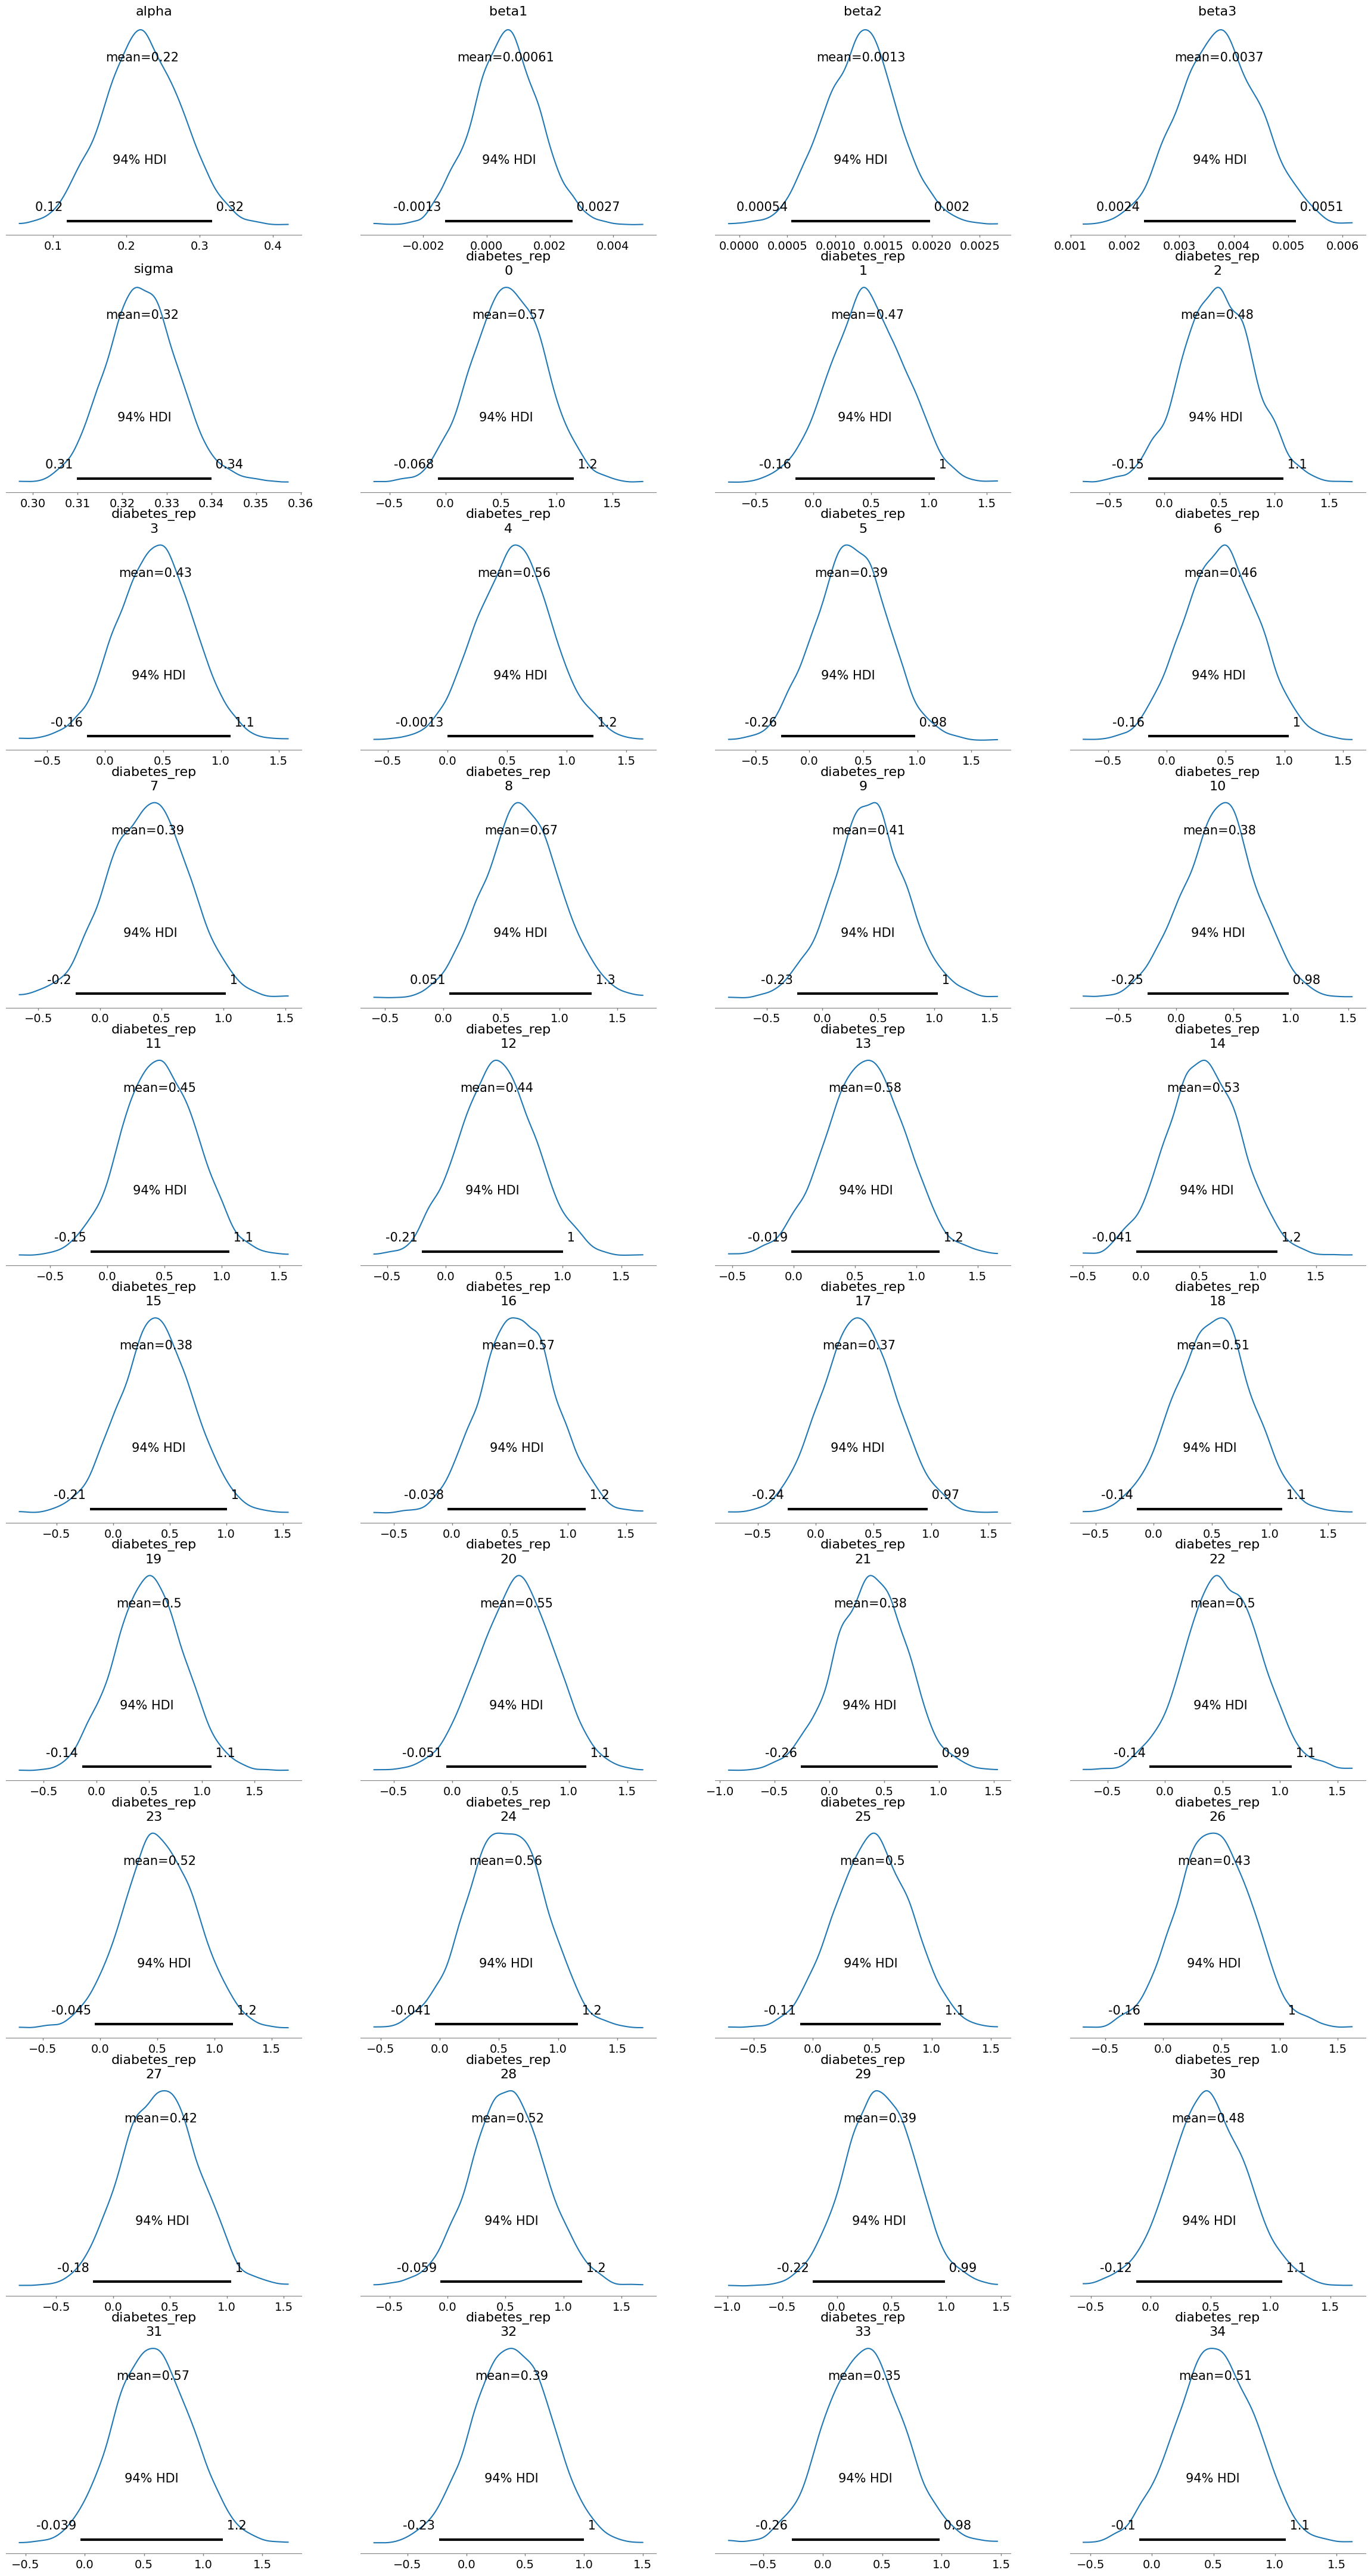

In [27]:
az.plot_posterior(fit)

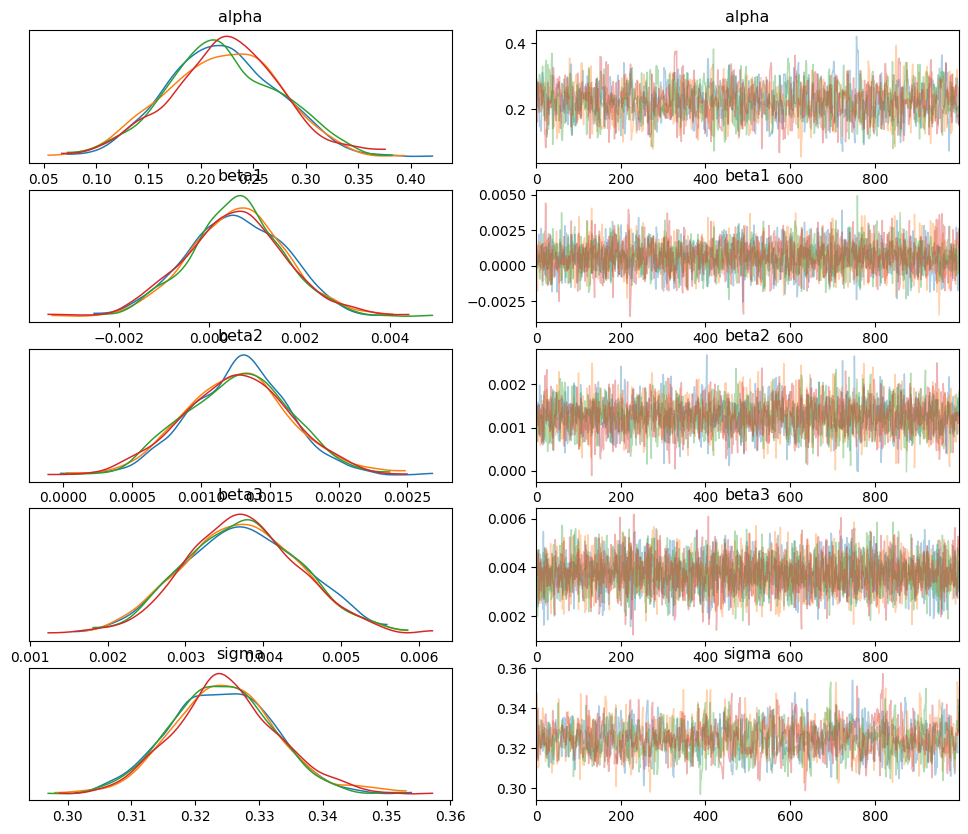

In [28]:
az.plot_trace(stan_data, compact=False);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

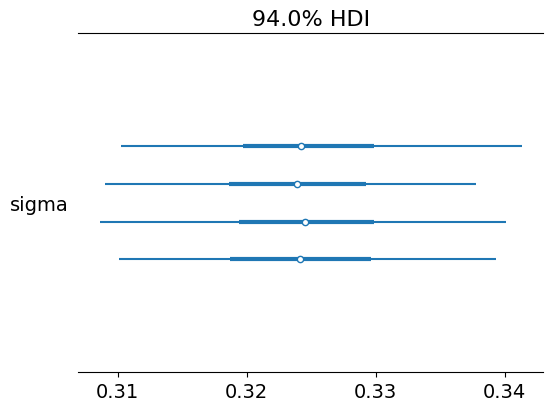

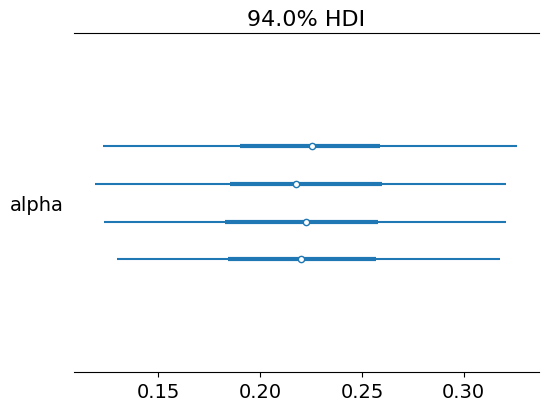

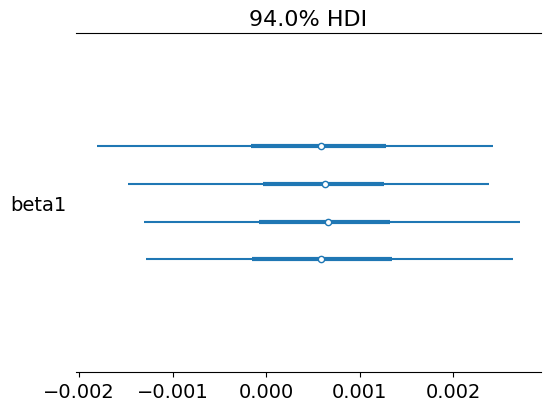

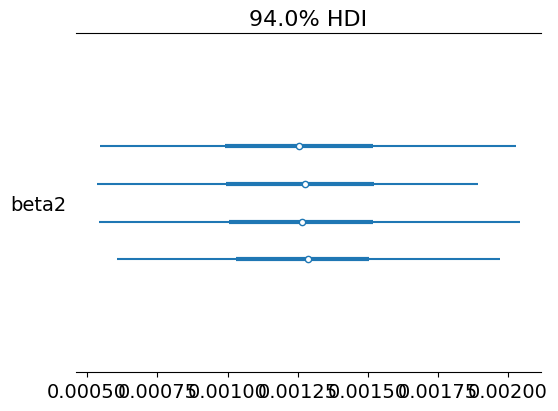

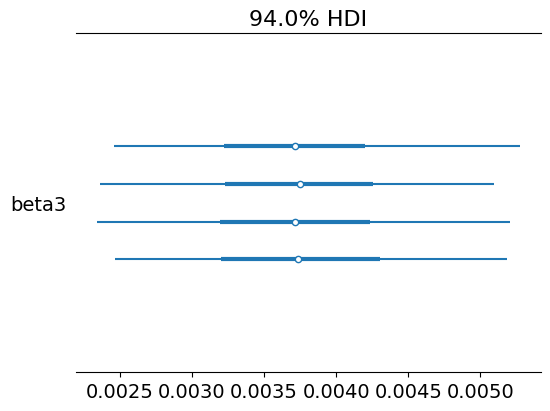

In [29]:
size = (10, 50)

az.plot_forest(stan_data.posterior.sigma)
az.plot_forest(stan_data.posterior.alpha)
az.plot_forest(stan_data.posterior.beta1)
az.plot_forest(stan_data.posterior.beta2)
az.plot_forest(stan_data.posterior.beta3)

In [30]:
print("alpha has a mean of ", output["alpha"].mean(), "and std of ", output["alpha"].std())

alpha has a mean of  0.22174714316865318 and std of  0.05312458295111521


In [31]:
print("beta has a mean of ", output["beta1"].mean(), "and std of ", output["beta1"].std())

beta has a mean of  0.0006077180915015405 and std of  0.0010668258848819082


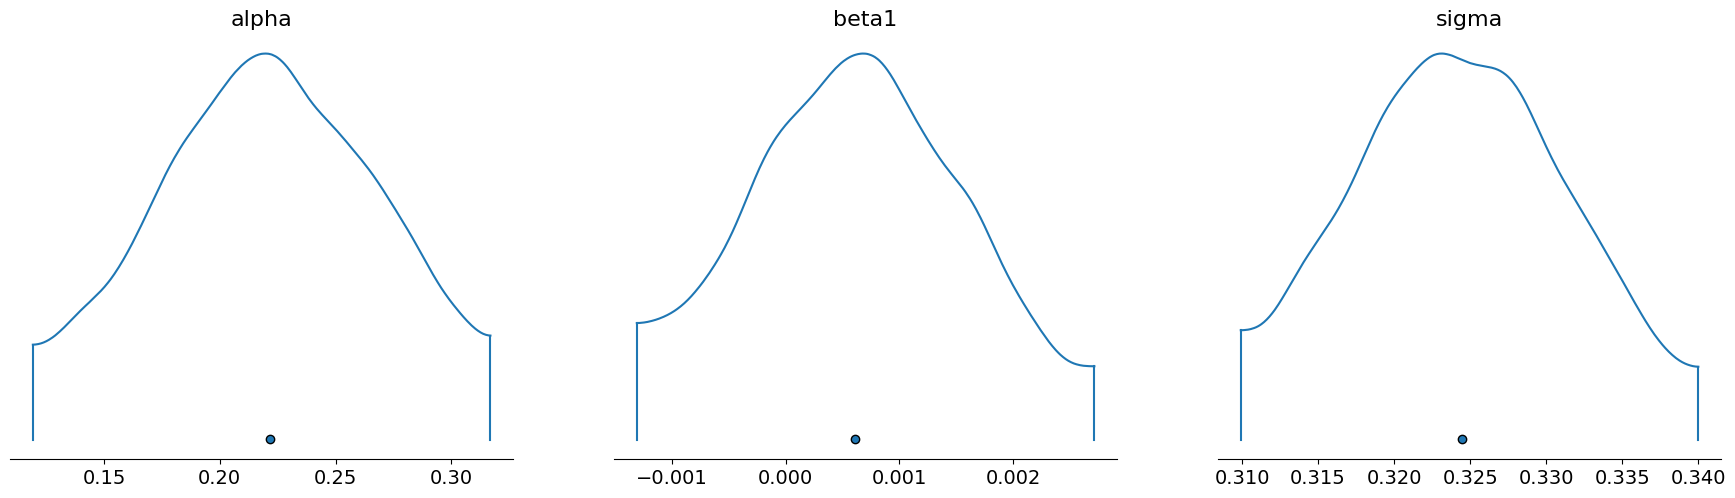

In [32]:
az.plot_density(fit, var_names=["alpha", "beta1", "sigma"]);


In [33]:
print(np.random.normal(1, 0.5, 5000))

[1.31666232 0.69815828 0.32982497 ... 0.68472238 1.09277512 1.04996443]


({'BF10': 0.4141086644592402, 'BF01': 2.4148251070907687},
 <Axes: title={'center': 'The BF_10 is 0.41\nThe BF_01 is 2.41'}, xlabel='a', ylabel='Density'>)

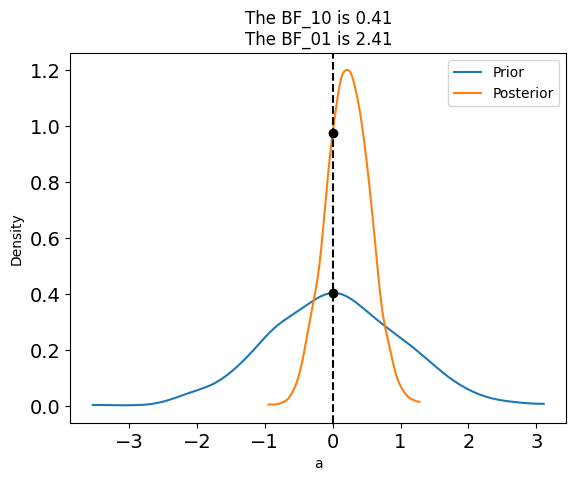

In [34]:
alpha = stan_data.posterior.alpha
beta1=  stan_data.posterior.beta1
beta2=  stan_data.posterior.beta2
beta3=  stan_data.posterior.beta3

x1 = np.random.normal(0, 1, 1000)
x2 = np.random.normal(0, 1, 1000)
x3 = np.random.normal(0, 1, 1000)

posterior_density = np.random.normal(alpha + beta1 * x1 + beta2 * x2 + beta3 * x3, stan_data.posterior.sigma)

idata = az.from_dict(
    posterior={"a": posterior_density}, prior={"a": np.random.normal(0, 1, 1000)}
)

az.plot_bf(idata, var_name="a", ref_val=0)

## 3. ploting

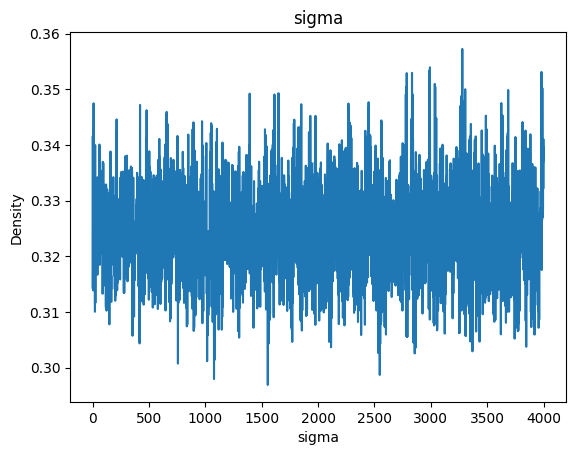

In [35]:
sigma = output["sigma"]  # array with shape (8, 4000)
sigma.plot()
plt.title('sigma')
plt.xlabel('sigma')
plt.ylabel('Density')
plt.show()

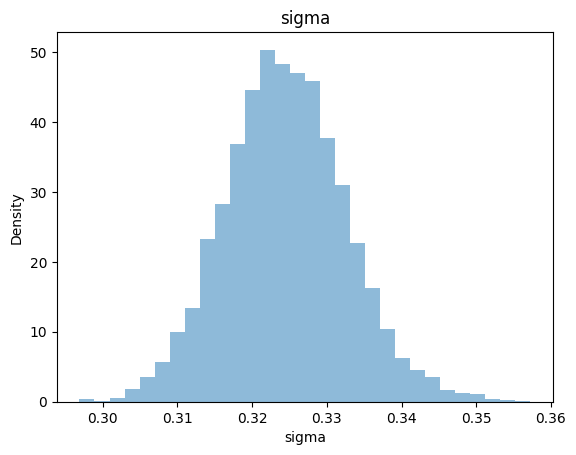

In [36]:
sigma = output["sigma"]  # array with shape (8, 4000)
sigma.plot.hist(bins=30, density=True, alpha=0.5)
plt.title('sigma')
plt.xlabel('sigma')
plt.ylabel('Density')
plt.show()

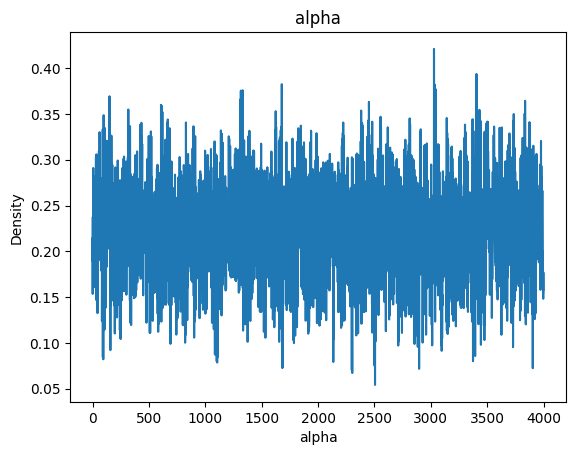

In [37]:
mu = output["alpha"]  # array with shape (8, 4000)
mu.plot()
plt.title('alpha')
plt.xlabel('alpha')
plt.ylabel('Density')
plt.show()

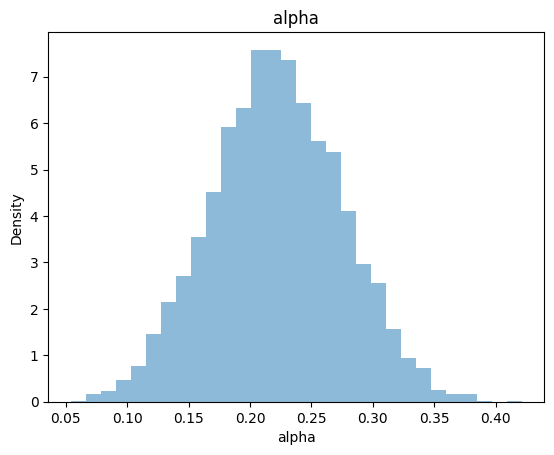

In [38]:
mu = output["alpha"]  # array with shape (8, 4000)
mu.plot.hist(bins=30, density=True, alpha=0.5)
plt.title('alpha')
plt.xlabel('alpha')
plt.ylabel('Density')
plt.show()

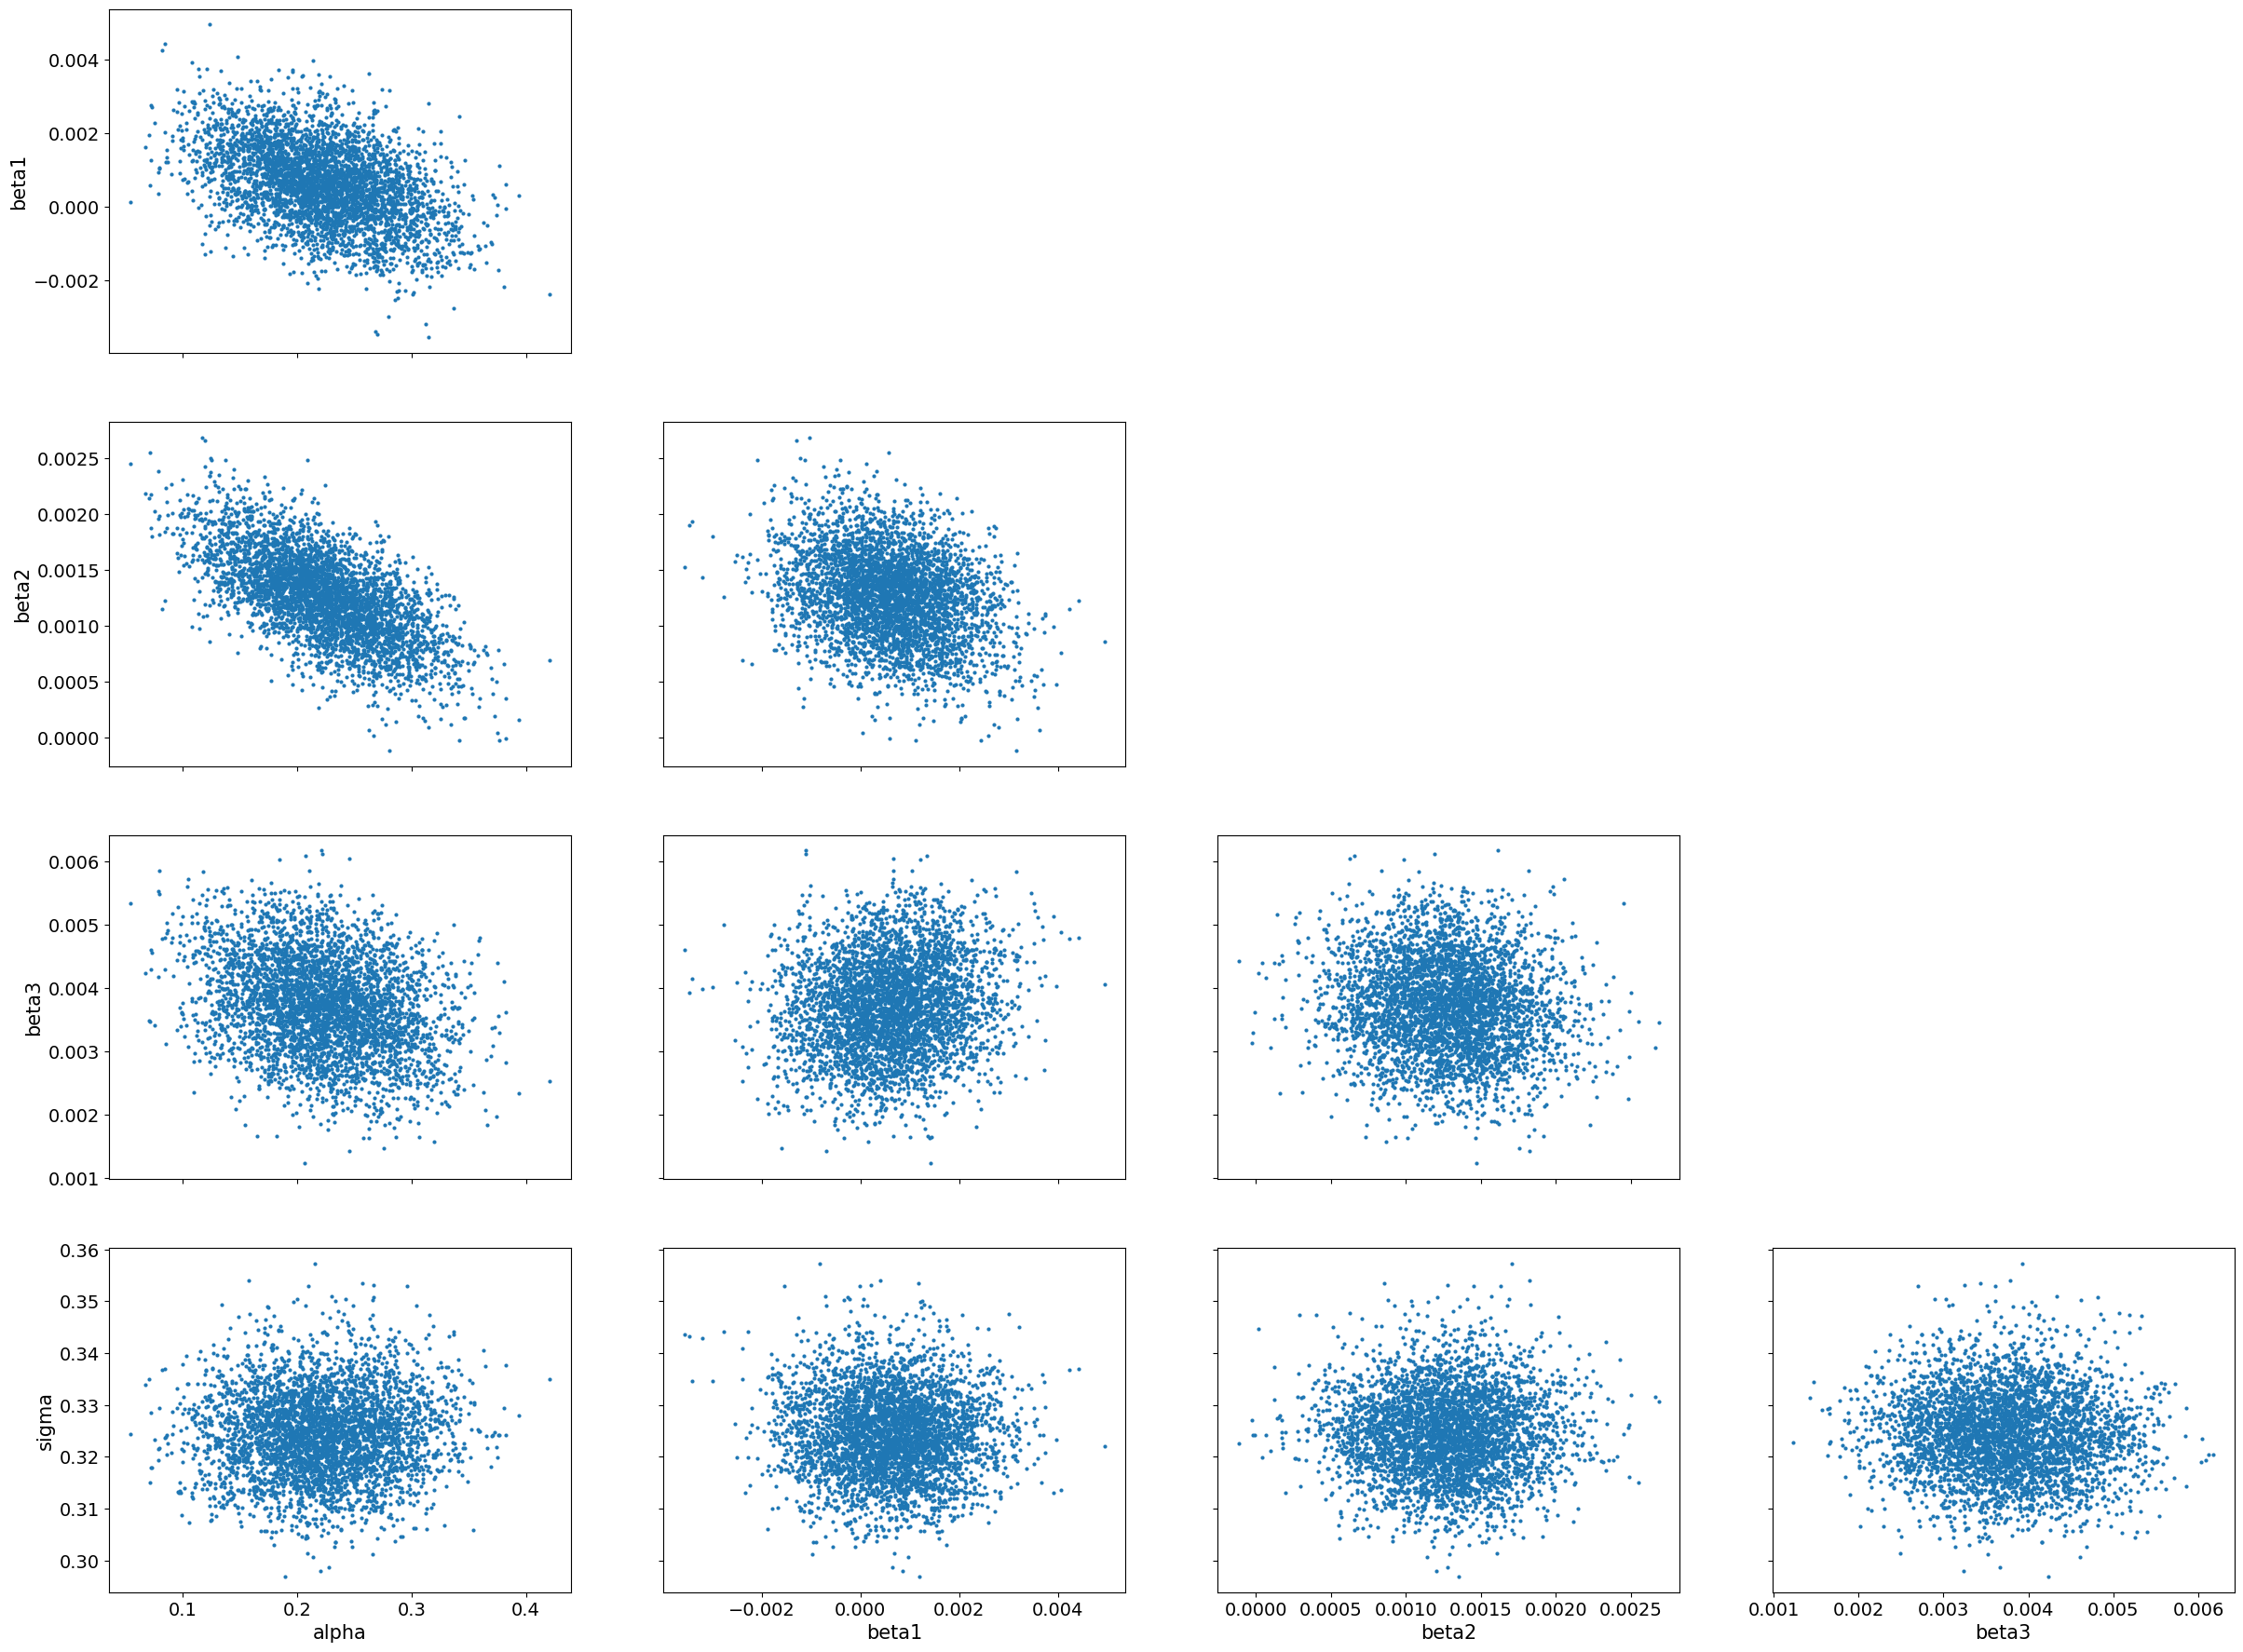

In [39]:
az.plot_pair(
    stan_data,
    divergences=True,
);

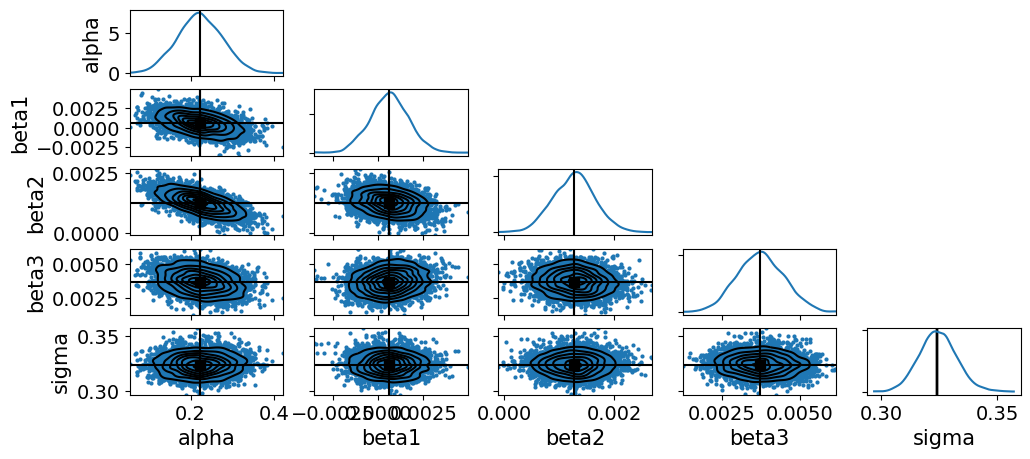

In [44]:
az.plot_pair(
    stan_data,
    divergences=True,
    var_names=["alpha", "beta1", "beta2",  "beta3", "sigma"],
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    # coords=coords,
    point_estimate="median",
    figsize=(11.5, 5),
);

## 0. delete cache of model

In [40]:
# import the relevant modules
import shutil
import httpstan.models
import httpstan.cache

In [41]:
httpstan.cache.list_model_names()

['models/p3daraxx',
 'models/st33u57o',
 'models/rrqnghow',
 'models/7h5zwkwk',
 'models/k3ychzqb']

In [42]:
httpstan.cache.delete_model_directory('models/7h5zwkwk') ## add the model pointer you want to remove

## 0. Saving model

In [43]:

def save(obj, filename):
    """Save compiled models for reuse."""
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    """Reload compiled models for reuse."""
    import pickle
    return pickle.load(open(filename, 'rb'))

In [2]:
# save(model, 'norm_model.pic')
# new_model = load('norm_model.pic')
